In [2]:
import sys
sys.path.insert(1,'../')

import numpy as np
from scipy import integrate
import scipy.constants as const
from scipy.optimize import minimize_scalar as minisc
from scipy import interpolate
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import importlib

import SC
import SCtheory as SCth

In [4]:
s = SC.TiN
points = 10

for Tc in [3.2, 3.6]:    
    s.kbTc = Tc*const.Boltzmann/const.e*1e6
    Ddata = np.zeros((3,points))
    kbTarr = np.logspace(np.log10(0.01),np.log10(.99),points)*s.kbTc
    for i in tnrange(len(kbTarr)):
        Ddata[0, i] = kbTarr[i]
        Ddata[1, i] = SCth.D(kbTarr[i],s)
        Ddata[2, i] = SCth.nqp(kbTarr[i],Ddata[1,i],s)
    Tcstr = str(np.around(
        s.kbTc/(const.Boltzmann/const.e*1e6),3
        )).replace('.','_')
    np.save(f'Ddata_{s.name}_{Tcstr}',Ddata)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\stevendr\surfdrive\SRON\Projects\Coding\Ddata\..\SCtheory\__init__.py:68: UserWarning: D calculation takes long.. 
 Superconductor=TiN
 N0=63000.0
 kbTD=49911.59425434488
 Tc=3.6
  warnings.warn(


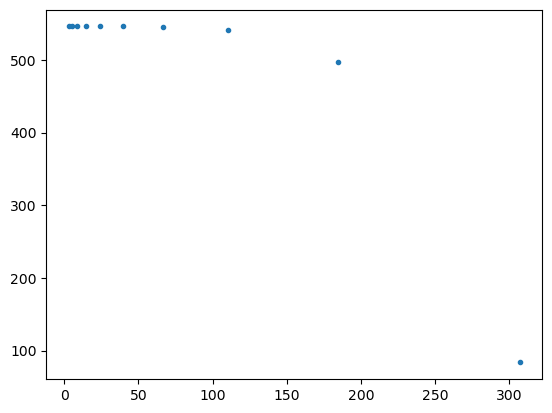

In [5]:
plt.plot(Ddata[0,:],Ddata[1,:],'.')

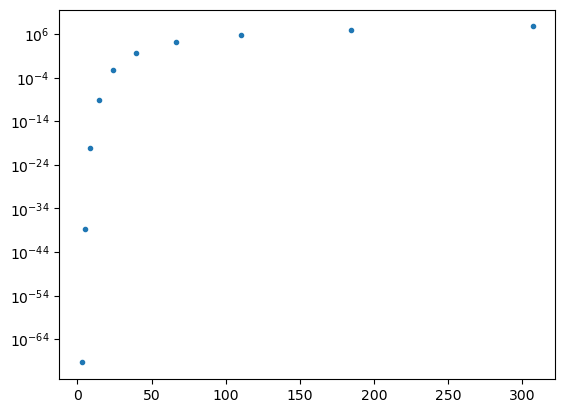

In [6]:
plt.plot(Ddata[0,:],Ddata[2,:], '.')
plt.yscale('log')

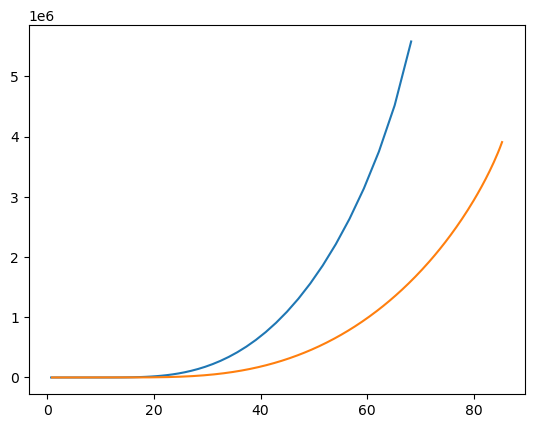

In [2]:
bTa = np.load('Ddata_bTa_0_8.npy')
Al = np.load('Ddata_Al_1_0.npy')
plt.plot(bTa[0, :], bTa[2, :])
plt.plot(Al[0, :], Al[2, :])